In [1]:
import json
import numpy as np
import parmed as pmd
import matplotlib.pyplot as plt

from paprika import analysis
from paprika import io
from paprika.restraints.utils import extract_guest_restraints

## Calculate free-energy

In [2]:
folder = "complex"
guest_resname = "CHL"
structure = pmd.load_file(
    f"{folder}/vac.prmtop", f"{folder}/vac.pdb", structure=True
)

#restraints = io.load_restraints(filepath="windows/restraints.json")
guest_restraints = io.load_restraints(filepath="windows/guest_restraints.json")
host_restraints = io.load_restraints(filepath="windows/host_restraints.json")

#guest_restraints = extract_guest_restraints(structure, restraints, guest_resname)

In [3]:
free_energy = analysis.fe_calc()
free_energy.topology = "system.pdb"
free_energy.trajectory = "production*.dcd"
free_energy.path = "windows"
free_energy.restraint_list = guest_restraints + host_restraints
free_energy.collect_data_from_json('APR_simulation_data.json')

In [4]:
free_energy.fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
free_energy.methods = ["ti-block"]#, "mbar-block"]
free_energy.ti_matrix = "diagonal"
free_energy.bootcycles = 1000
free_energy.compute_free_energy()

/shared/compounds/pAPRika/paprika/analysis.py:649: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data_points = [len(np.asarray(x).T) for x in self.simulation_data[phase]]
/shared/compounds/pAPRika/paprika/analysis.py:976: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  force_constants_T = np.asarray(force_constants).T * force_units
/shared/compounds/pAPRika/paprika/analysis.py:977: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  targets_T = np.asarray(targets).T * target_units


In [5]:
free_energy.compute_ref_state_work([
    guest_restraints[0], guest_restraints[1], None, None,
    guest_restraints[2], None
])

/shared/compounds/pAPRika/paprika/analysis.py:1330: UserWarning: Converting restraint list to dictionary, make sure the restraints are listed in the order of [`r`, `theta`,`phi`, `alpha`, `beta`, `gamma`].
  warnings.warn(


In [6]:
results = free_energy.results


### Binding free-energy

In [7]:
def print_binding(results, method="ti-block"):
    fe_a = -1 * results["attach"][method]["fe"]
    sem_a = results["attach"][method]["sem"]
    fe_p = -1 * results["pull"][method]["fe"]
    sem_p = results["pull"][method]["sem"]
    fe_r = results["release"][method]["fe"]
    sem_r = results["release"][method]["sem"]
    fe_ref = -1 * results["ref_state_work"]

    binding = fe_a + fe_p + fe_r + fe_ref
    sem = np.sqrt(sem_a ** 2 + sem_p ** 2 + sem_r ** 2)

    print(f"Analysis - {method}")
    print("-" * 25)
    print(f"Attach free-energy  = {fe_a:6.2f} +/- {sem_a:0.2f} kcal/mol")
    print(f"Pull free-energy    = {fe_p:6.2f} +/- {sem_p:0.2f} kcal/mol")
    print(f"Release free-energy = {fe_r:6.2f} +/- {sem_r:0.2f} kcal/mol")
    print(f"Ref state-work      = {fe_ref:6.2f}")
    print(f"Binding free-energy = {binding:6.2f} +/- {sem:0.2f} kcal/mol\n")


print_binding(results, method="ti-block")
#print_binding(results, method="mbar-autoc")

Analysis - ti-block
-------------------------
Attach free-energy  = -16.28 kilocalorie / mole +/- 0.34 kilocalorie / mole kcal/mol
Pull free-energy    = -7.62 kilocalorie / mole +/- 1.11 kilocalorie / mole kcal/mol
Release free-energy = 3.04 kilocalorie / mole +/- 0.04 kilocalorie / mole kcal/mol
Ref state-work      = 7.01 kilocalorie / mole
Binding free-energy = -13.85 kilocalorie / mole +/- 1.16 kilocalorie / mole kcal/mol



In [8]:
def get_fe_convergence(results, method="ti-block"):
    convergence = {}

    # Free energy
    attach = results["attach"][method]["fraction_fe"]
    pull = results["pull"][method]["fraction_fe"]
    release = results["release"][method]["fraction_fe"]
    
    keys = sorted(attach.keys())
    unit = attach[keys[0]].units

    convergence["fe_a"] = -1 * np.array([np.array(attach[i]) for i in keys]) * unit
    convergence["fe_p"] = -1 * np.array([np.array(pull[i]) for i in keys]) * unit
    convergence["fe_r"] = np.array([np.array(release[i]) for i in keys]) * unit
    convergence["ref"] = -1 * results["ref_state_work"]

    convergence["fractions"] = np.array([i for i in attach])

    # Error
    attach = results["attach"][method]["fraction_sem"]
    pull = results["pull"][method]["fraction_sem"]
    release = results["release"][method]["fraction_sem"]

    convergence["sem_a"] = np.array([np.array(attach[i]) for i in keys])
    convergence["sem_p"] = np.array([np.array(pull[i]) for i in keys])
    convergence["sem_r"] = np.array([np.array(release[i]) for i in keys])

    convergence["binding"] = (
        convergence["fe_a"]
        + convergence["fe_p"]
        + convergence["fe_r"]
        + convergence["ref"]
    )
    convergence["sem"] = (
        convergence["sem_a"] ** 2
        + convergence["sem_p"] ** 2
        + convergence["sem_r"] ** 2
    ) ** 0.5

    return convergence


convergence = get_fe_convergence(results, method="ti-block")

/tmp/ipykernel_22988/3328650632.py:12: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  convergence["fe_a"] = -1 * np.array([np.array(attach[i]) for i in keys]) * unit
/tmp/ipykernel_22988/3328650632.py:13: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  convergence["fe_p"] = -1 * np.array([np.array(pull[i]) for i in keys]) * unit
/tmp/ipykernel_22988/3328650632.py:14: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  convergence["fe_r"] = np.array([np.array(release[i]) for i in keys]) * unit
/tmp/ipykernel_22988/3328650632.py:24: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  convergence["sem_a"] = np.array([np.array(attach[i]) for i in keys])
/tmp/ipykernel_22988/3328650632.py:25: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  convergence["sem_p"] = np.array([np.array(pull[i]) for i 

### Free-energy plots

/tmp/ipykernel_22988/3113137461.py:18: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(results["attach"]["ti-block"]["fe_matrix"][0, :]),
/tmp/ipykernel_22988/3113137461.py:19: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  yerr=np.array(results["attach"]["ti-block"]["sem_matrix"][0, :]),
/tmp/ipykernel_22988/3113137461.py:29: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(results["pull"]["ti-block"]["fe_matrix"][0, :]),
/tmp/ipykernel_22988/3113137461.py:30: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  yerr=np.array(results["pull"]["ti-block"]["sem_matrix"][0, :]),
/tmp/ipykernel_22988/3113137461.py:40: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(results["release"]["ti-block"]["fe_matrix"][0, :]),
/tmp/ipykernel_22988/3113137461.py:41: UnitStripped

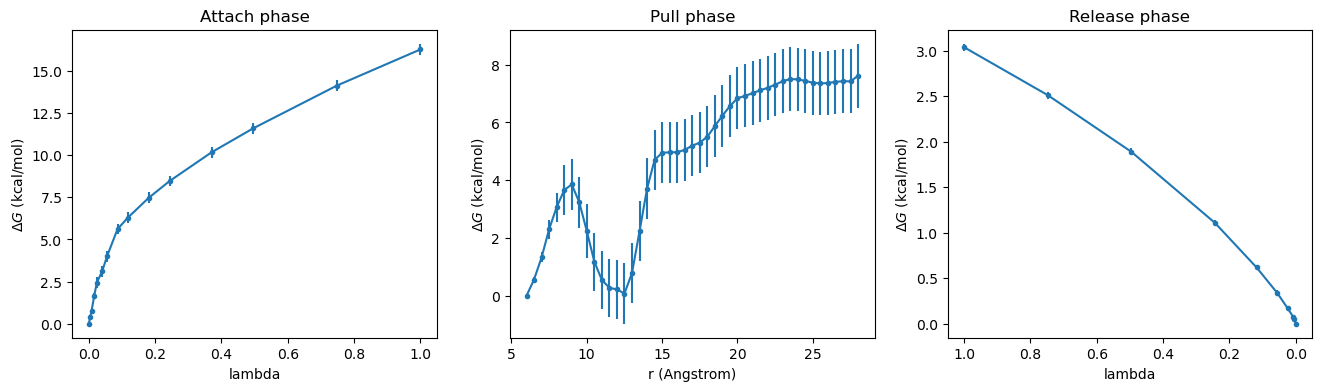

In [9]:
attach_string = (
    "0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 18.10 24.40 37.00 49.60 74.80 100.00"
)
release_string = (
    "0.00 0.40 0.80 2.40 5.50 11.80 24.40 49.60 74.80 100.00"
)
attach_fractions = [float(i) / 100 for i in attach_string.split()]
release_fractions = [float(i) / 100 for i in release_string.split()]

initial_distance = 6.0
dr = 0.5
pull_distances = np.arange(0.0 + initial_distance, 22 + initial_distance + dr, dr)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.errorbar(
    attach_fractions,
    np.array(results["attach"]["ti-block"]["fe_matrix"][0, :]),
    yerr=np.array(results["attach"]["ti-block"]["sem_matrix"][0, :]),
    fmt=".-",
)
plt.xlabel("lambda")
plt.ylabel(r"$\Delta G$ (kcal/mol)")
plt.title("Attach phase")

plt.subplot(1, 3, 2)
plt.errorbar(
    pull_distances,
    np.array(results["pull"]["ti-block"]["fe_matrix"][0, :]),
    yerr=np.array(results["pull"]["ti-block"]["sem_matrix"][0, :]),
    fmt=".-",
)
plt.xlabel("r (Angstrom)")
plt.ylabel(r"$\Delta G$ (kcal/mol)")
plt.title("Pull phase")

ax1 = plt.subplot(1, 3, 3)
ax1.errorbar(
    release_fractions,
    np.array(results["release"]["ti-block"]["fe_matrix"][0, :]),
    yerr=np.array(results["release"]["ti-block"]["sem_matrix"][0, :]),
    fmt=".-",
)
ax1.set_xlabel("lambda")
ax1.set_ylabel(r"$\Delta G$ (kcal/mol)")
ax1.set_title("Release phase")
ax1.invert_xaxis()

/shared/miniconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:3282: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y, dtype=object)


Text(0.5, 1.0, 'Binding free energy')

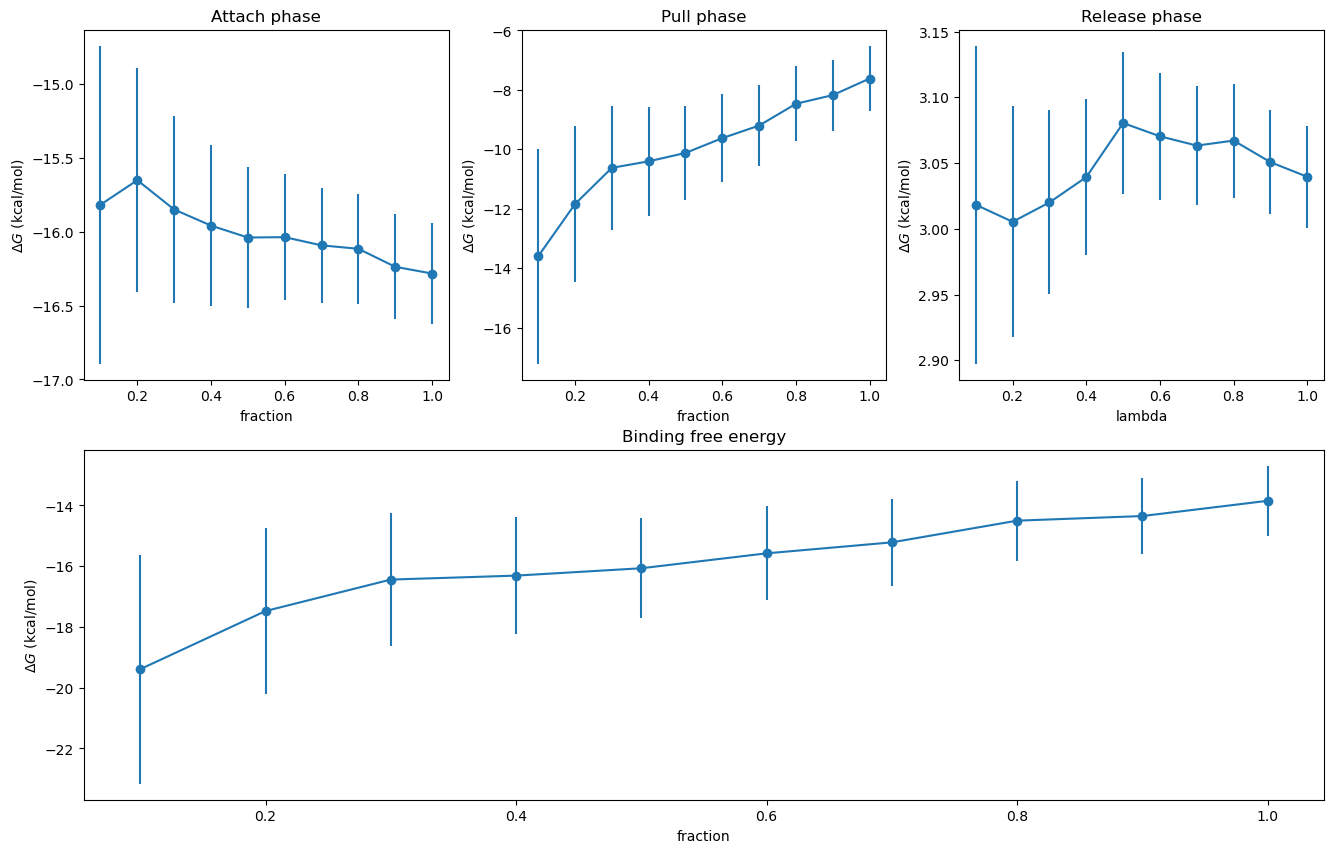

In [10]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 3, 1)
plt.errorbar(
    convergence["fractions"], convergence["fe_a"], yerr=convergence["sem_a"], fmt="o-"
)
plt.xlabel("fraction")
plt.ylabel(r"$\Delta G$ (kcal/mol)")
plt.title("Attach phase")

plt.subplot(2, 3, 2)
plt.errorbar(
    convergence["fractions"], convergence["fe_p"], yerr=convergence["sem_p"], fmt="o-"
)
plt.xlabel("fraction")
plt.ylabel(r"$\Delta G$ (kcal/mol)")
plt.title("Pull phase")

ax1 = plt.subplot(2, 3, 3)
ax1.errorbar(
    convergence["fractions"], convergence["fe_r"], yerr=convergence["sem_r"], fmt="o-"
)
ax1.set_xlabel("lambda")
ax1.set_ylabel(r"$\Delta G$ (kcal/mol)")
ax1.set_title("Release phase")
# ax1.invert_xaxis()

plt.subplot(2, 1, 2)
plt.errorbar(
    convergence["fractions"], convergence["binding"], yerr=convergence["sem"], fmt="o-"
)
plt.xlabel("fraction")
plt.ylabel(r"$\Delta G$ (kcal/mol)")
plt.title("Binding free energy")

## Plot overlap

In [11]:
def return_intersection(hist1, hist2):
    minima = np.minimum(hist1, hist2)
    intersect_1 = np.true_divide(np.sum(minima), np.sum(hist1))
    intersect_2 = np.true_divide(np.sum(minima), np.sum(hist2))
    return np.array([intersect_1, intersect_2])

### Pull Phase

In [12]:
trajectory = free_energy.simulation_data["pull"]
n_windows = np.shape(trajectory)[0]
n_bins = 30
overlap = np.zeros(n_windows)

for j in range(n_windows - 1):
    min_x = np.min(trajectory[j][0])
    max_x = np.max(trajectory[j + 1][0])
    hist1, _ = np.histogram(np.array(trajectory[j][0]), bins=n_bins, range=[min_x.magnitude, max_x.magnitude])
    hist2, _ = np.histogram(np.array(trajectory[j + 1][0]), bins=n_bins, range=[min_x.magnitude, max_x.magnitude])
    intersection = return_intersection(hist1, hist2)
    overlap[j] = intersection[0]
overlap[-1] = intersection[1]

/shared/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2009: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result = asarray(a).shape
/tmp/ipykernel_22988/3909349771.py:9: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  hist1, _ = np.histogram(np.array(trajectory[j][0]), bins=n_bins, range=[min_x.magnitude, max_x.magnitude])
/tmp/ipykernel_22988/3909349771.py:10: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  hist2, _ = np.histogram(np.array(trajectory[j + 1][0]), bins=n_bins, range=[min_x.magnitude, max_x.magnitude])


/tmp/ipykernel_22988/1506203329.py:11: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(free_energy.simulation_data["pull"][i][0]), bins=301, range=(0, 30), density=True


Text(0, 0.5, 'fractional overlap')

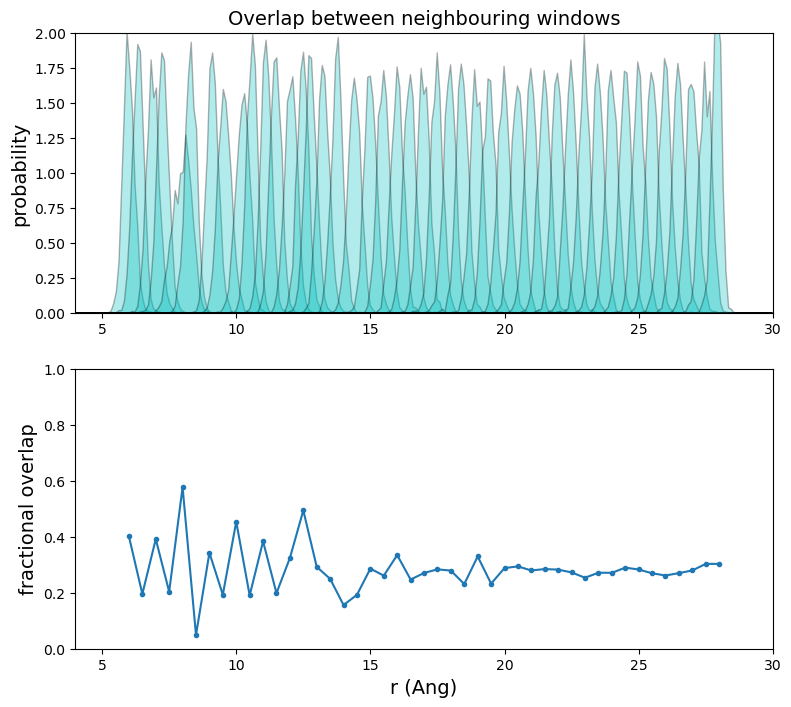

In [13]:
plt.figure(figsize=(9, 8))

ax1 = plt.subplot(211)
ax1.clear()
ax1.axis([4.0, 30.0, 0.0, 2.0])
ax1.set_ylabel("probability", fontsize=14)
ax1.set_title("Overlap between neighbouring windows", fontsize=14)

for i in range(len(free_energy.simulation_data["pull"])):
    hist, bins = np.histogram(
        np.array(free_energy.simulation_data["pull"][i][0]), bins=301, range=(0, 30), density=True
    )
    center = (bins[:-1] + bins[1:]) / 2
    ax1.fill_between(
        center,
        hist * 0.0,
        hist,
        facecolor="c",
        edgecolor="k",
        alpha=0.3,
    )

ax2 = plt.subplot(212)
ax2.clear()
ax2.axis([4.0, 30.0, 0.0, 2.0])
pull_distance = np.linspace(6, 28, 45)
ax2.plot(pull_distance, overlap, ".-")
ax2.set_ylim(0, 1)
ax2.set_xlabel("r (Ang)", fontsize=14)
ax2.set_ylabel("fractional overlap", fontsize=14)

### Attach Phase

In [14]:
trajectory = free_energy.simulation_data["attach"]
n_windows = np.shape(trajectory)[0]
n_bins = 30
overlap = np.zeros(n_windows)

for j in range(n_windows - 1):
    min_x = np.min(trajectory[j][0])
    max_x = np.max(trajectory[j + 1][0])
    hist1, _ = np.histogram(np.array(trajectory[j][0]), bins=n_bins, range=[min_x.magnitude, max_x.magnitude])
    hist2, _ = np.histogram(np.array(trajectory[j + 1][0]), bins=n_bins, range=[min_x.magnitude, max_x.magnitude])
    intersection = return_intersection(hist1, hist2)
    overlap[j] = intersection[0]
overlap[-1] = intersection[1]

/tmp/ipykernel_22988/1267133645.py:9: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  hist1, _ = np.histogram(np.array(trajectory[j][0]), bins=n_bins, range=[min_x.magnitude, max_x.magnitude])
/tmp/ipykernel_22988/1267133645.py:10: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  hist2, _ = np.histogram(np.array(trajectory[j + 1][0]), bins=n_bins, range=[min_x.magnitude, max_x.magnitude])


/tmp/ipykernel_22988/994748981.py:11: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(free_energy.simulation_data["attach"][i][0]),


Text(0, 0.5, 'fractional overlap')

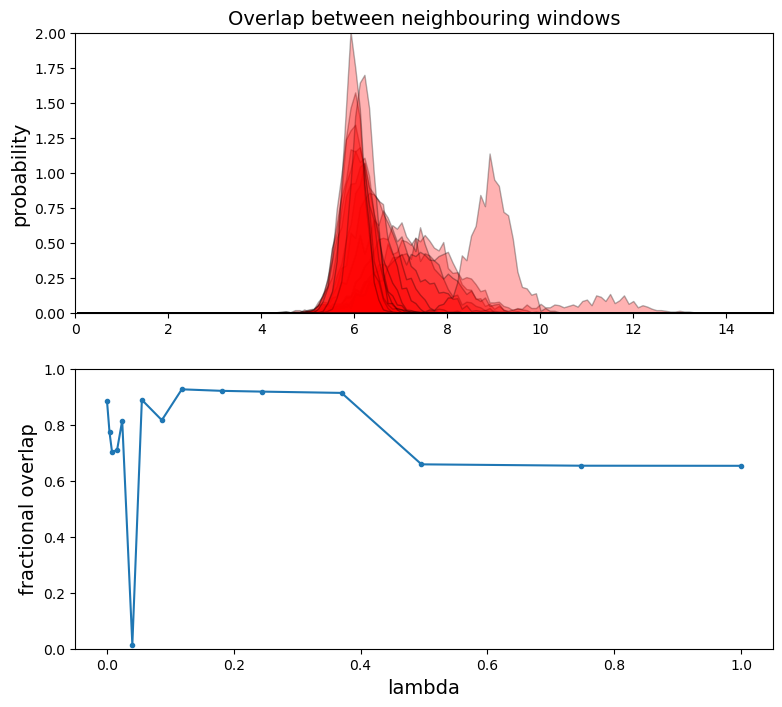

In [15]:
plt.figure(figsize=(9, 8))

ax1 = plt.subplot(211)
ax1.clear()
ax1.axis([0.0, 15.0, 0.0, 2.0])
ax1.set_ylabel("probability", fontsize=14)
ax1.set_title("Overlap between neighbouring windows", fontsize=14)

for i in range(len(free_energy.simulation_data["attach"])):
    hist, bins = np.histogram(
        np.array(free_energy.simulation_data["attach"][i][0]),
        bins=301,
        range=(0, 30),
        density=True,
    )
    center = (bins[:-1] + bins[1:]) / 2
    ax1.fill_between(
        center,
        hist * 0.0,
        hist,
        facecolor="r",
        edgecolor="k",
        alpha=0.3,
    )

ax2 = plt.subplot(212)
ax2.clear()
# ax2.axis([0.0,5.0,0.0,2.0])
ax2.plot(attach_fractions, overlap, ".-")
ax2.set_ylim(0, 1)
ax2.set_xlabel("lambda", fontsize=14)
ax2.set_ylabel("fractional overlap", fontsize=14)